In [1]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt

from synthpop.infer import Infer, SMCABC

/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model(generator):
    n_agents = 1000
    agent_ages, agent_sexes = generator(n_agents)
    males = []
    females = []
    for age, sex in zip(agent_ages, agent_sexes):
        if sex == 0:
            males.append(age)
        else:
            females.append(age)
    return [torch.tensor(males), torch.tensor(females)]

def loss(x):
    age_males, age_females = x
    return torch.abs(1 - torch.abs(torch.mean(age_males) - torch.mean(age_females))).reshape(1,1)

def meta_generator(params):
    mu_male, mu_female = params
    def generator(n_agents):
        sex_dist = torch.distributions.Categorical(torch.tensor([0.5, 0.5]))
        sexes = sex_dist.sample((n_agents,))
        mus = torch.tensor([mu_male, mu_female])
        mus = mus[sexes]
        age_dist = torch.distributions.Normal(mus, 1.0)
        ages = torch.clamp(age_dist.sample(), min=0.0)
        return ages, sexes
    return generator

In [3]:
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([10., 10]), 
                                                                    torch.tensor([90., 90])),
                                                                    reinterpreted_batch_ndims=1)

In [4]:
infer = Infer(model=model, meta_generator=meta_generator, prior=prior, loss=loss)

In [5]:

infer_method = SMCABC(num_particles = 100, num_initial_pop=5_000, num_simulations=10_000, epsilon_decay=0.5)
trained_meta_generator = infer.fit(infer_method, num_workers=-1)

Running 5000 simulations in 5000 batches.: 100%|██████████| 5000/5000 [00:05<00:00, 855.31it/s] 
/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)
Running 24 simulations in 24 batches.: 100%|██████████| 24/24 [00:00<00:00, 264.31it/s]


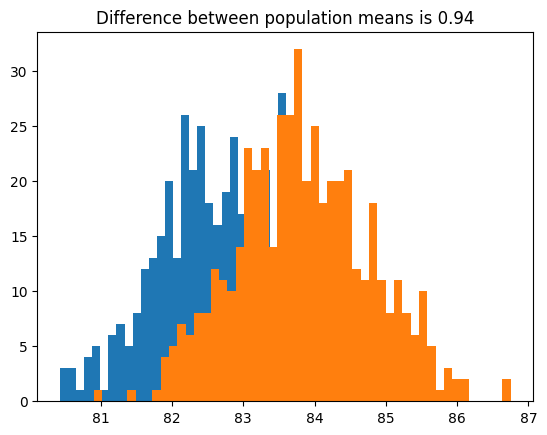

In [6]:
generator = trained_meta_generator()
ages_males, ages_females = model(generator)

f, ax = plt.subplots()
ax.hist(ages_males.numpy(), bins=50, label="male")
ax.hist(ages_females.numpy(), bins=50, label="female");
mean_diff = torch.abs(ages_males.mean() - ages_females.mean()).item()
ax.set_title(f"Difference between population means is {mean_diff:.2f}")
f.savefig("../docs/_static/age_example.png", dpi=150, bbox_inches="tight")